In [1]:
#import machine-learning and data processing libraries.
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from skimage import io,transform
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from torch.autograd import Variable
import torch.nn.functional as F

In [2]:
device = torch.device('cuda:0') # needed in order to train model in GPU
batch_size = 38 

In [3]:
# reading labels in dataframe ---- data preprocessing
full = pd.read_csv('labels.csv').reset_index()
doglist = pd.DataFrame(pd.read_csv('labels.csv')['breed'].unique(),columns=['breed']).reset_index()
pd.merge(full,doglist,how ='left',on = 'breed').to_csv('doglist.csv',index=False)

In [4]:
print('Number of training images :',len(pd.read_csv('doglist.csv')))

Number of training images : 10222


In [5]:
#dataloader
class dogdata(Dataset):
    def __init__(self, dirroot,transform=None):
        self.labels = pd.read_csv('doglist.csv')
        self.transform = transform
        self.dirroot = dirroot
    def __len__(self):
        return len(self.labels)
    def __getitem__(self,idx):
        fgimg = io.imread(self.dirroot+"\\"+self.labels['id'][idx]+'.jpg')
        if self.transform:
            fgimg = self.transform(fgimg)
        return fgimg, self.labels['index_y'][idx]

In [6]:
scale_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.ToTensor()
])

In [7]:
dogset = dogdata(dirroot = '..\\..\\..\\..\\Google Drive\\dogbreeds\\train\\train',transform = scale_transform)

In [8]:
trainloader = torch.utils.data.DataLoader(dogset, batch_size=batch_size, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(dogset, batch_size=batch_size, shuffle=True, num_workers=0)

#### lets see what one of out pictures look like

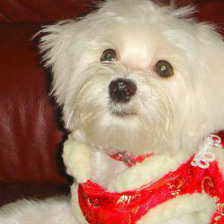

In [9]:
to_pil = torchvision.transforms.ToPILImage()
img = to_pil(dogset[12][0])
img

###### important:
###### For conv_layers and maxpool_layer
###### input_size-filter_size/stride + 1 = output_size if padding = 0

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3,10,kernel_size = 4, stride= 2)
        self.conv2 = nn.Conv2d(10,20,kernel_size = 7, stride= 2)
        self.conv3 = nn.Conv2d(20,40,kernel_size = 4, stride =2)
        self.mp = nn.MaxPool2d(3, stride = 1)
        self.fc = nn.Linear(19360,120) #22*22*40=19360
    def forward(self,x):
        x = F.relu(self.mp(self.conv1(x))) #output = 109 by 109 by 10
        x = F.relu(self.mp(self.conv2(x))) # output = 50 by 50 by 20
        x = F.relu(self.mp(self.conv3(x))) # output = 22 by 22 by 40
        #print(x.size())
        x = x.view(batch_size,-1)
        #print(x.size())
        x= self.fc(x)
        return F.log_softmax(x)

### Define model and optimizer

In [11]:
model = Net().cuda()
optimizer = optim.SGD(model.parameters(),lr = 0.02, momentum=0.5)

In [12]:
# training loop
def train():
    model.train()
    for batch_idx, (data, target) in enumerate(trainloader):
        data = Variable(data).cuda()
        target = Variable(target).cuda()
        target = target.type(torch.cuda.LongTensor)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

In [13]:
# testing loop
def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in testloader:
        data, target = Variable(data, volatile=True).cuda(), Variable(target).cuda()
        target = target.type(torch.cuda.LongTensor)
        output = model(data)
        # sum up batch loss
        test_loss += F.nll_loss(output, target, size_average=False).data[0]
        # get the index of the max log-probability
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        
    test_loss /= len(testloader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%) epoch: {}'.format(test_loss, correct, len(testloader.dataset),100. * correct / len(testloader.dataset),epoch))

In [14]:
for epoch in range(1, 30):
    train()
    test()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # This is added back by InteractiveShellApp.init_path()



Test set: Average loss: 4.7648, Accuracy: 157/10222 (1%) epoch: 1

Test set: Average loss: 4.6614, Accuracy: 245/10222 (2%) epoch: 2

Test set: Average loss: 4.4722, Accuracy: 411/10222 (4%) epoch: 3

Test set: Average loss: 4.3716, Accuracy: 556/10222 (5%) epoch: 4

Test set: Average loss: 4.3212, Accuracy: 634/10222 (6%) epoch: 5

Test set: Average loss: 4.1581, Accuracy: 928/10222 (9%) epoch: 6

Test set: Average loss: 4.1628, Accuracy: 922/10222 (9%) epoch: 7

Test set: Average loss: 3.9669, Accuracy: 1179/10222 (11%) epoch: 8

Test set: Average loss: 3.8784, Accuracy: 1339/10222 (13%) epoch: 9

Test set: Average loss: 3.9050, Accuracy: 1302/10222 (12%) epoch: 10

Test set: Average loss: 3.7985, Accuracy: 1471/10222 (14%) epoch: 11

Test set: Average loss: 3.6486, Accuracy: 1769/10222 (17%) epoch: 12

Test set: Average loss: 3.5536, Accuracy: 1963/10222 (19%) epoch: 13

Test set: Average loss: 3.5592, Accuracy: 2054/10222 (20%) epoch: 14

Test set: Average loss: 3.4847, Accuracy: 

In [15]:
happy = io.imread('happy.jpg')

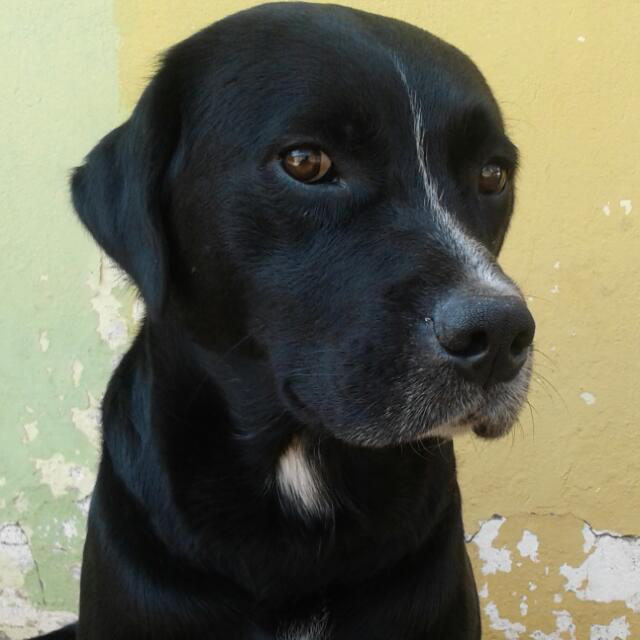

In [16]:
Image.open('happy.jpg')

In [17]:
happy = torch.tensor(happy,device = device)
happy = scale_transform(happy)

In [18]:
happy.size()

torch.Size([3, 224, 224])

In [19]:
happy =  Variable(happy).cuda()
model.eval()
batch_size  = 1
with torch.no_grad():
      outputs = model(happy.unsqueeze_(0))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [20]:
pd.read_csv('doglist.csv').loc[np.argmax(outputs).item()]['breed']

'walker_hound'

ohk, so happy was classified as a walker hound when he is  in actual fact a Labrador Retriever :(  
There are multiple ways we could improve our model. A few of which are:

* add test-time augmentation
* increase our dataset with data augmentation

but first we need to properly visualise our train and test accuracies, in order to make a determination of wheather to increase the capacity of our network.